# Notebook

## Cleaning the Data

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import code.data_preparation as dp
import code.visualizations as viz
from geopy.geocoders import Nominatim

Here is the data provided.

In [2]:
train_values = pd.read_csv('data/training_set_values.csv')
train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

##### Missing Values

As we can see there are a number of columns with missing values, all of them are object datatypes, which makes deciding what to do with them more complex.

In [4]:
train_values.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

We will drop the scheme_name column and fill the remaining null values with the label "unknown"

In [5]:
train_values = train_values.drop(columns=['scheme_name'])
train_values = train_values.fillna('unknown')

In [6]:
train_values.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
w

##### Duplicate Values

There are no duplicate id numbers, so there are not obvious duplicate rows.

In [7]:
train_values.id.value_counts().max()

1

Many columns seem to contain very similar information.

*Potential Duplicate Columns: Extraction Type*

In [8]:
train_values.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [9]:
train_values.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [10]:
train_values.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

*Potential Duplicate Columns: Management*

In [11]:
train_values.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [12]:
train_values.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

*Potential Duplicate Columns: Payment*

In [13]:
train_values.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [14]:
train_values.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

*Potential Duplicate Columns: Water Quality*

In [15]:
train_values.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [16]:
train_values.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

*Potential Duplicate Columns: Water Quantity*

In [17]:
train_values.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [18]:
train_values.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

*Potential Duplicate Columns: Source*

In [19]:
train_values.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [20]:
train_values.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [21]:
train_values.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

*Potential Duplicate Columns: Waterpoint*

In [22]:
train_values.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [23]:
train_values.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

We will drop all the columns with the fewest classes. From each of these groups.

In [24]:
columns_dropped = ['extraction_type_group', 
                   'extraction_type_class',
                   'management_group',
                   'payment_type',
                   'quality_group',
                   'quantity_group',
                   'source_type',
                   'source_class',
                   'waterpoint_type_group']
rm_duplicate_df = train_values.drop(columns = columns_dropped)

In [25]:
rm_duplicate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 59400 non-null  int64  
 1   amount_tsh         59400 non-null  float64
 2   date_recorded      59400 non-null  object 
 3   funder             59400 non-null  object 
 4   gps_height         59400 non-null  int64  
 5   installer          59400 non-null  object 
 6   longitude          59400 non-null  float64
 7   latitude           59400 non-null  float64
 8   wpt_name           59400 non-null  object 
 9   num_private        59400 non-null  int64  
 10  basin              59400 non-null  object 
 11  subvillage         59400 non-null  object 
 12  region             59400 non-null  object 
 13  region_code        59400 non-null  int64  
 14  district_code      59400 non-null  int64  
 15  lga                59400 non-null  object 
 16  ward               594

Many of the categorical data columns have thousands of unique labels, which could cause real issues with dimensionality if straightforwardly one-hot encoded.

In [26]:
values_per_column = [(col, rm_duplicate_df[col].value_counts().count()) 
                     for col in rm_duplicate_df.columns]
values_per_column

[('id', 59400),
 ('amount_tsh', 98),
 ('date_recorded', 356),
 ('funder', 1898),
 ('gps_height', 2428),
 ('installer', 2145),
 ('longitude', 57516),
 ('latitude', 57517),
 ('wpt_name', 37400),
 ('num_private', 65),
 ('basin', 9),
 ('subvillage', 19288),
 ('region', 21),
 ('region_code', 27),
 ('district_code', 20),
 ('lga', 125),
 ('ward', 2092),
 ('population', 1049),
 ('public_meeting', 3),
 ('recorded_by', 1),
 ('scheme_management', 13),
 ('permit', 3),
 ('construction_year', 55),
 ('extraction_type', 18),
 ('management', 12),
 ('payment', 7),
 ('water_quality', 8),
 ('quantity', 5),
 ('source', 10),
 ('waterpoint_type', 7)]

##### Location Data

Beyond lat-long there are a number of location data columns, let's look through them a bit to decide how to proceed.

In [27]:
train_values.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [28]:
train_values.subvillage.value_counts()

Madukani      508
Shuleni       506
Majengo       502
Kati          373
unknown       371
             ... 
Chiminoka       1
Nyang'Huba      1
Iteleja         1
Mighisui        1
Kaulangumi      1
Name: subvillage, Length: 19288, dtype: int64

In [29]:
(train_values.subvillage.value_counts()==1).sum()

9424

In [30]:
train_values.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [31]:
train_values.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [32]:
train_values.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [33]:
train_values.lga.value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [34]:
train_values.ward.value_counts()

Igosi          307
Imalinyi       252
Siha Kati      232
Mdandu         231
Nduruma        217
              ... 
Korongoni        1
Kitete           1
Mkumbi           1
Machinjioni      1
Nsemulwa         1
Name: ward, Length: 2092, dtype: int64

In [35]:
(train_values.ward.value_counts()==1).sum()

30

We will drop the region columns since that data seems to be captured in the region codes, but will otherwise keep the others since they seem to be location groupings at different scales which might be useful for having information about different scales of geographic effects.

In [36]:
rm_duplicate_df = rm_duplicate_df.drop(columns = ['region'])

##### Unique Identifier info and Random Data

The id number and wpt_name which is the name of the individual waterpump shouldn't be used in predictions, and thus will be dropped. The num_private is a column that there is no info on what it represents and is filled with zero values. The 'recorded_by' column only has one value and thus will be useless. We will drop these as well.

Finally since we aren't doing a time analysis we will drop the date recorded info.

In [37]:
rm_duplicate_df.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [38]:
clean_train_values = rm_duplicate_df.drop(columns = ['id', 'wpt_name', 'num_private', 'date_recorded', 'recorded_by'])

In [39]:
clean_train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   funder             59400 non-null  object 
 2   gps_height         59400 non-null  int64  
 3   installer          59400 non-null  object 
 4   longitude          59400 non-null  float64
 5   latitude           59400 non-null  float64
 6   basin              59400 non-null  object 
 7   subvillage         59400 non-null  object 
 8   region_code        59400 non-null  int64  
 9   district_code      59400 non-null  int64  
 10  lga                59400 non-null  object 
 11  ward               59400 non-null  object 
 12  population         59400 non-null  int64  
 13  public_meeting     59400 non-null  object 
 14  scheme_management  59400 non-null  object 
 15  permit             59400 non-null  object 
 16  construction_year  594

#### Looking at the Numerical Data

It appears there may be some zero values in the data or extreme outliers, but we will look more closely to check.

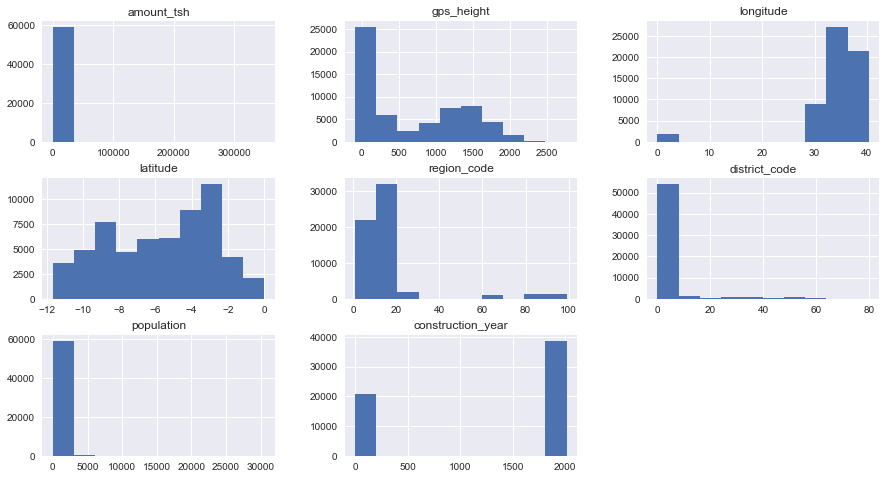

In [40]:
clean_train_values.hist(figsize = (15,8));

#### Total Static Head

Total static head is a measure of how many feet a pump can lift water. It is hard to tell if zero values are missing or if they represent systems that don't lift water. We won't impute any values for this for now, but may impute the median value as a test in the future.

In [41]:
clean_train_values.amount_tsh.value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

#### Construction Year

Unless the pumps were literal built in the classical era, zeroes here are obviously missing values.

In [42]:
clean_train_values.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

We will impute these with the median value of the remaining data.

In [43]:
clean_train_values['construction_year'][clean_train_values['construction_year']!=0].median()

2000.0

In [44]:
clean_train_values['construction_year'] = clean_train_values['construction_year'].replace(0, 2000)

In [45]:
clean_train_values.construction_year.value_counts()

2000    22800
2010     2645
2008     2613
2009     2533
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1996      811
1980      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

#### Population

There is no way to tell whether the zero and 1 values represent that no one or one person is using the pump or if it is missing data. It is likely missing data, but without pulling in additional data on populations in wards and making some assumptions about how many people would use the pump, there is no reasonable choice for what to impute.

In [111]:
clean_train_values.population.value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

#### GPS Data

Both lat and long are missing values 1812 values. We can tell because a longitude of 0 would be outside the country.

In [46]:
clean_train_values.longitude.value_counts()

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64

In [47]:
clean_train_values.latitude.value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

There are many zeros in the height data, but it is impossible to entirely tell which are just sea level and which might be missing. But, it seems that the rows with missing lat-long are also have zeroes in thier heights and thus are likely missing height info.

In [48]:
clean_train_values.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [49]:
clean_train_values['gps_height'][clean_train_values.longitude==0].value_counts()

0    1812
Name: gps_height, dtype: int64

Let's look more closely at some of the rows with 0 lat long data.

In [56]:
clean_train_values[clean_train_values.longitude==0].head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region_code,district_code,...,scheme_management,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type
21,0.0,Dwsp,0,DWE,0.0,-2.000000e-08,Lake Victoria,Ibabachegu,17,1,...,WUG,False,2000,swn 80,wug,unknown,unknown,unknown,shallow well,hand pump
53,0.0,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Lake Victoria,Center,19,6,...,VWC,True,2000,submersible,vwc,unknown,unknown,dry,machine dbh,communal standpipe multiple
168,0.0,Wvt,0,WVT,0.0,-2.000000e-08,Lake Victoria,Ilula,17,1,...,Parastatal,False,2000,gravity,parastatal,other,soft,seasonal,rainwater harvesting,communal standpipe
177,0.0,Netherlands,0,DWE,0.0,-2.000000e-08,Lake Victoria,Mahaha,17,1,...,WUG,False,2000,other,wug,unknown,soft,enough,shallow well,other
253,0.0,Hesawa,0,DWE,0.0,-2.000000e-08,Lake Victoria,Nyamatala,19,2,...,unknown,True,2000,nira/tanira,vwc,never pay,soft,insufficient,shallow well,hand pump


In [57]:
clean_train_values[clean_train_values.longitude==0]['region_code'].value_counts()

17    1057
19     752
11       3
Name: region_code, dtype: int64

In [58]:
clean_train_values[clean_train_values.longitude==0]['district_code'].value_counts()

1    1057
6     488
2     264
4       3
Name: district_code, dtype: int64

There are 194 other locations in the region 17 and district 1 with lat-long data.

In [59]:
clean_train_values[(clean_train_values['district_code']==1) & 
                   (clean_train_values['region_code']== 17) &
                   (clean_train_values.longitude != 0)]['region_code'].count()

194

There are 2473 other locations in the region 11 and district 4 with lat-long data.

In [60]:
clean_train_values[(clean_train_values['district_code']==4) & 
                   (clean_train_values['region_code']== 11) &
                   (clean_train_values.longitude != 0)]['region_code'].count()

2473

There are no other locations in region 19 and district 6 with lat-long data. All 488 are missing data.

In [61]:
clean_train_values[(clean_train_values['district_code']==6) & 
                   (clean_train_values['region_code']== 19) &
                   (clean_train_values.longitude != 0)]['region_code'].count()

0

In [62]:
clean_train_values[(clean_train_values['district_code']==6) & 
                   (clean_train_values['region_code']== 19)]['region_code'].count()

488

There are 475 other locations in region 19 and district 2 with lat-long data.

In [63]:
clean_train_values[(clean_train_values['district_code']==2) & 
                   (clean_train_values['region_code']== 19) &
                   (clean_train_values.longitude != 0)]['region_code'].count()

475

In [64]:
clean_train_values[clean_train_values.longitude==0]['ward'].value_counts().head()

Chinamili      111
Nkololo         80
Somanda         72
Bumera          71
Kalangalala     66
Name: ward, dtype: int64

We can perhaps use geopy to get the lat-long for the wards in the missing data.

In [81]:
app = Nominatim(user_agent="nonlocal_lia")
# get location raw data
location = app.geocode("Chinamili, Tanzania")
# print raw data
print(location)

Chinamili, Itilima, Simiyu, Lake Zone, Tanzania


In [83]:
location.latitude

-2.8838455

In [89]:
def get_ward_lat_long(ward):
    app = Nominatim(user_agent="nonlocal_lia")
    if app.geocode(ward+', Tanzania'):
        location = app.geocode(ward+', Tanzania')
        return (location.latitude, location.longitude)
    return None

In [90]:
get_ward_lat_long('Chinamili')

(-2.8838455, 34.1768636)

In [92]:
def make_ward_dict(ward_list):
    output = {}
    for ward in ward_list:
        if get_ward_lat_long(ward):
            output[ward] = get_ward_lat_long(ward)
        else:
            output[ward] = 'Missing'
    return output

In [93]:
ward_dict = make_ward_dict(clean_train_values[clean_train_values.longitude==0]['ward'].unique())

In [94]:
ward_dict

{'Ikungulyabashashi': (-2.6154987, 33.9392423),
 "Nyang'hwale": (-3.0508948, 32.5961406),
 'Chinamili': (-2.8838455, 34.1768636),
 'Bunamhala': (-2.8707347, 34.0248122),
 'Malili': (-2.4454849, 33.8055692),
 'Kalangalala': (-2.8747658, 32.2301629),
 'Shigala': (-2.390133, 33.65925),
 'Kasamwa': (-2.8427991, 32.4235486),
 'Zagayu': (-2.9761145, 33.7723867),
 'Nkungulu': (-3.0070171, 33.4157514),
 'Mwaubingi': 'Missing',
 'Mhango': (-2.75, 33.9166667),
 'Nyaluhande': (-2.5013382, 33.6107922),
 'Nyakabindi': (-2.651869, 33.978696),
 'Dutwa': (-2.5093101, 33.9686528),
 'Kabita': (-2.32762, 33.6465756),
 'Nkololo': (-2.6423973, 34.1600706),
 'Gamboshi': 'Missing',
 'Mwaswale': (-2.819208, 34.3193193),
 'Somanda': (-2.776197, 33.9939907),
 'Katoro': (-3.0048496, 31.927419),
 'Lugulu': (-3.2594213, 34.9247185),
 'Kalemela': (-4.5385852, 33.4498171),
 'Sakwe': (-2.7652258, 33.8579992),
 'Busolwa': (-3.0025795, 32.6312332),
 'Kasoli': (-2.5795663, 33.6780681),
 'Lubanga': (-2.6310997, 32.402812

In [98]:
still_missing = []
for name, location in ward_dict.items():
    if location == 'Missing':
        still_missing.append(name)
still_missing

['Mwaubingi', 'Gamboshi', 'Mwananyili']

In [103]:
for missing in still_missing:
    print(missing, clean_train_values[clean_train_values.ward==missing]['region_code'].unique())
    print(missing, clean_train_values[clean_train_values.ward==missing]['district_code'].unique())

Mwaubingi [17]
Mwaubingi [1]
Gamboshi [17]
Gamboshi [1]
Mwananyili [19]
Mwananyili [2]


For the wards not in the geocode API, we will simply impute the mean value for the lat-long of their district.

In [104]:
for missing in still_missing:
    region = clean_train_values[clean_train_values.ward == missing]['region_code'].unique()[0]
    district = clean_train_values[clean_train_values.ward == missing]['district_code'].unique()[0]
    long_mean = clean_train_values[(clean_train_values['district_code']== district) &
                                    (clean_train_values['region_code']== region) &
                                    (clean_train_values.longitude != 0)]['longitude'].mean()
    lat_mean = clean_train_values[(clean_train_values['district_code']== district) &
                                    (clean_train_values['region_code']== region) &
                                    (clean_train_values.longitude != 0)]['latitude'].mean()
    ward_dict[missing] = (lat_mean, long_mean)

In [105]:
ward_dict

{'Ikungulyabashashi': (-2.6154987, 33.9392423),
 "Nyang'hwale": (-3.0508948, 32.5961406),
 'Chinamili': (-2.8838455, 34.1768636),
 'Bunamhala': (-2.8707347, 34.0248122),
 'Malili': (-2.4454849, 33.8055692),
 'Kalangalala': (-2.8747658, 32.2301629),
 'Shigala': (-2.390133, 33.65925),
 'Kasamwa': (-2.8427991, 32.4235486),
 'Zagayu': (-2.9761145, 33.7723867),
 'Nkungulu': (-3.0070171, 33.4157514),
 'Mwaubingi': (-2.9641030569587623, 34.19313730118557),
 'Mhango': (-2.75, 33.9166667),
 'Nyaluhande': (-2.5013382, 33.6107922),
 'Nyakabindi': (-2.651869, 33.978696),
 'Dutwa': (-2.5093101, 33.9686528),
 'Kabita': (-2.32762, 33.6465756),
 'Nkololo': (-2.6423973, 34.1600706),
 'Gamboshi': (-2.9641030569587623, 34.19313730118557),
 'Mwaswale': (-2.819208, 34.3193193),
 'Somanda': (-2.776197, 33.9939907),
 'Katoro': (-3.0048496, 31.927419),
 'Lugulu': (-3.2594213, 34.9247185),
 'Kalemela': (-4.5385852, 33.4498171),
 'Sakwe': (-2.7652258, 33.8579992),
 'Busolwa': (-3.0025795, 32.6312332),
 'Kasoli'

In [107]:
for ward in ward_dict.keys():
    idx = clean_train_values[(clean_train_values['ward'] == ward) &
                             (clean_train_values.longitude == 0)].index
    lat_column_num = clean_train_values.columns.get_loc('latitude')
    long_column_num = clean_train_values.columns.get_loc('longitude')
    clean_train_values.iloc[idx, lat_column_num] = ward_dict[ward][0]
    clean_train_values.iloc[idx, long_column_num] = ward_dict[ward][1]

In [108]:
clean_train_values[clean_train_values.longitude==0]['region_code'].value_counts()

Series([], Name: region_code, dtype: int64)

Unfortunately the geocode API doesn't have altitude data for the locations. We will impute that the the height for the data from the districts with more lat-long data is the mean for the district. For region 19 district 6 we will leave the zeros in place since there is no surrounding data to use.

In [109]:
# Gathering means
# Using uncleaned df to gather means and indexes since lat/long of clean is altered in cleaned df
height_mean_17_1 = clean_train_values[(train_values['district_code']==1) &
                                    (train_values['region_code']== 17) &
                                    (train_values.longitude != 0)]['gps_height'].mean() 
height_mean_11_4 = clean_train_values[(train_values['district_code']==4) &
                                    (train_values['region_code']== 11) &
                                    (train_values.longitude != 0)]['gps_height'].mean()
height_mean_19_2 = clean_train_values[(train_values['district_code']==2) &
                                    (train_values['region_code']== 19) &
                                    (train_values.longitude != 0)]['gps_height'].mean()

# Indexes of Data with missing lat-long
missing_idx_17_1 = clean_train_values[(train_values['district_code']==1) &
                                    (train_values['region_code']== 17) &
                                    (train_values.longitude == 0)].index
missing_idx_11_4 = clean_train_values[(train_values['district_code']==4) &
                                    (train_values['region_code']== 11) &
                                    (train_values.longitude == 0)].index
missing_idx_19_2 = clean_train_values[(train_values['district_code']==2) &
                                    (train_values['region_code']== 19) &
                                    (train_values.longitude == 0)].index

clean_train_values.iloc[missing_idx_17_1, clean_train_values.columns.get_loc('gps_height')] = height_mean_17_1
clean_train_values.iloc[missing_idx_11_4, clean_train_values.columns.get_loc('gps_height')] = height_mean_11_4
clean_train_values.iloc[missing_idx_19_2, clean_train_values.columns.get_loc('gps_height')] = height_mean_19_2

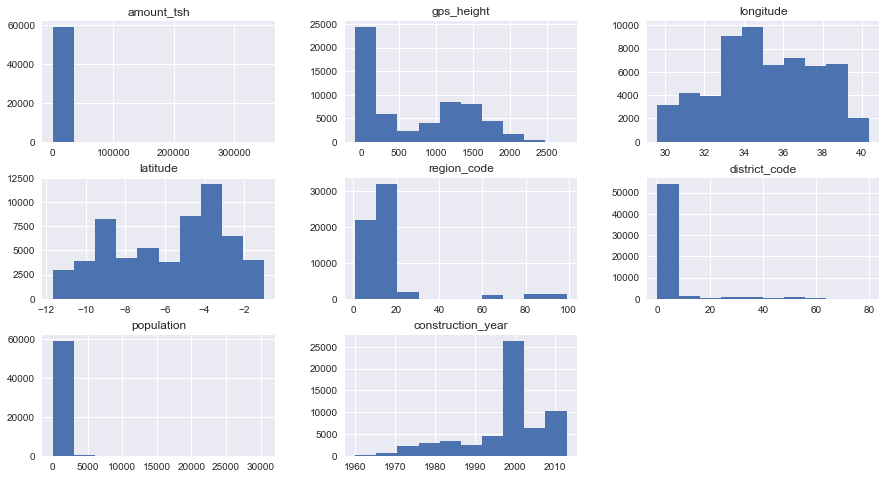

In [110]:
clean_train_values.hist(figsize = (15,8));

There is obviously still a lot of missing data, but let's proceed.

#### Label Data

There are no missing labels in the label data.

In [ ]:
train_labels = pd.read_csv('data/training_set_labels.csv')
train_labels.head()

In [ ]:
train_labels.info()

There are three possible labels for the data.

In [ ]:
train_labels.status_group.value_counts()

## Building a Base Model

To begin, let's see how well a logistic model run with the categorical data label encoded performs and use that as our baseline.

In [ ]:
from sklearn.